# 🛠 Data Cleaning Process

The dataset used in this analysis is sourced from [TU Graz Computational Geotechnics Database](https://www.tugraz.at/en/institutes/ibg/research/computational-geotechnics-group/database).  
It contains all the necessary information, including **Soil Behavior Type (SBT) classification**.  

Although the dataset already includes SBT classification, this example **reprocesses the data** by performing **data cleaning** and applying a similar methodology to the one used in the [Geoparameters Characterization Package](https://github.com/DanielChou0916/CPTu_data_analysis/blob/main/geoparams/Geoparameters.ipynb) to re-estimate SBT classification.

---

## **📌 Data Cleaning Steps**
1. **Remove missing values**  
   - Drop rows containing `NaN` in the following essential features: **depth, cone resistance $q_t$, sleeve friction $f_s$, pore water pressure $u_2$, and hydrostatic pressure $u_0$**.  

2. **Filter invalid measurements**  
   - Exclude data points where **negative sleeve friction values** are recorded.  

3. **Iterate through each location** based on the `"basin_valley"` feature.  

4. **Iterate through each borehole** within each location.  

5. **Within each borehole sub-dataframe:**  
   - Remove duplicate depth data points to ensure consistency.  

6. **Extract key CPTu features**  
   - Retain **depth, cone resistance (and $q_t$ is converted into kPa from MPa), sleeve friction, pore water pressure, and hydrostatic pressure** for further processing.  

7. **Perform CPTu parameter characterization calculations.**  

8. **Store processed data into a dictionary.**  

9. **Merge all locations and boreholes** into a single **machine learning dataset**.  

10. **Export the cleaned dataset to CSV format.**  
## Click [here](https://www.kaggle.com/datasets/danielchouvae/cptu-cleaned-dataset) to download the cleaned dataset.
---

## **📊 Purpose of Data Cleaning**
- Ensure **consistency and reliability** in CPTu feature extraction.  
- Eliminate **erroneous or redundant data points** before machine learning training.  

---

## Before and after cleaning, the distribution of each SBT class are shown here:
![Description](cleaning.png)

---

## 📫 Contact  
For any questions or discussions, feel free to reach out via [LinkedIn](https://linkedin.com/in/daniel-t-chou-1b51661b2).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
from CPT_functions import*


# 🛠 Implementing Steps 1–8

The data cleaning process follows the structured methodology outlined in the previous section (Steps 1–8),  
which includes filtering invalid data, handling missing values, and standardizing CPTu feature extraction.  

This section executes these steps programmatically, ensuring the dataset is prepared for further analysis.


In [2]:
# Read CSV file
df = pd.read_csv("CPT_PremstallerGeotechnik_revised.csv")
np.seterr(all="ignore")  # Suppress warnings

# 🛠 Step 1: Data Cleaning
# Remove rows with missing values in critical columns
df_cleaned = df.dropna(subset=['Depth (m)', 'fs (kPa)', 'qt (MPa)', 'u2 (kPa)', 'u0 (kPa)'])

# Remove invalid sleeve friction values
df_cleaned = df_cleaned[df_cleaned['fs (kPa)'] > 0]

# 🏗 Step 2: Organize by Location and Borehole
profile = {}  # Dictionary to store processed data

for loc in df_cleaned['basin_valley'].unique():
    df_loc = df_cleaned[df_cleaned['basin_valley'] == loc].copy()
    profile[loc] = {}

    for borehole in df_loc['ID'].unique():
        df_borehole = df_loc[df_loc['ID'] == borehole].copy()

        # 🛠 Step 3: Sort by Depth and Remove Duplicates
        df_borehole = df_borehole.sort_values(by='Depth (m)').reset_index(drop=True)
        df_borehole = df_borehole.drop_duplicates(subset=["Depth (m)"], keep="first")

        # 📊 Step 4: Extract Required CPTu Features
        Depth = df_borehole['Depth (m)'].to_numpy()
        qt = df_borehole['qt (MPa)'].to_numpy() * 1000  # Convert to kPa
        fs = df_borehole['fs (kPa)'].to_numpy()
        u2 = df_borehole['u2 (kPa)'].to_numpy()
        u0 = df_borehole['u0 (kPa)'].to_numpy()

        # ⚠️ Step 5: Validate Depth Consistency
        layer_thickness = np.diff(Depth, prepend=0)
        if np.any(layer_thickness <= 0):
            print(f"\n⚠️ Warning: Non-increasing depth values detected!")
            print(f"🔹 Location: {loc}, Borehole: {borehole}")

        # 🏗 Step 6: Compute CPTu Parameters
        gamma_t = unit_weight_cal(fs)
        sigma_v0 = total_stress_cal(gamma_t, Depth)
        sigma_eff = sigma_eff_cal(sigma_v0, u0)
        q_net, delta_u = qnet_deltau(qt, sigma_v0, u0, u2)
        Q, F, Bq = Normalized_piez_paras(q_net, sigma_eff, fs, delta_u)
        I_c = I_c_calculation(Q, F)
        n, Qtn = Qtn_n(I_c, sigma_eff, q_net)
        Ic_m = Ic_m_calculation(Qtn, F)
        soil_type, SBT_Zone = classification_soil(Ic_m, F, Qtn)
        soil_behavior = est_soil_behavior(Ic_m)
        phi_eff = phi_eff_cal(soil_behavior, Q, Bq, Qtn)
        m_p, yield_sig, OCR = OCR_estimation(Ic_m, q_net, sigma_eff)

        # 💾 Step 7: Store Processed Data in Dictionary
        profile[loc][borehole] = {
            'Depth': Depth,
            'qt': qt,
            'fs': fs,
            'u2': u2,
            'gamma_t': gamma_t,
            'sigma_v0': sigma_v0,
            'u0': u0,
            'sigma_eff': sigma_eff,
            'q_net': q_net,
            'delta_u': delta_u,
            'Q': Q,
            'F': F,
            'Bq': Bq,
            'I_c': I_c,
            'n': n,
            'Qtn': Qtn,
            'Ic_m': Ic_m,
            'soil_type': soil_type,
            'SBT_Zone': SBT_Zone,
            'soil_behavior': soil_behavior,
            'phi_eff': phi_eff,
            'm_p': m_p,
            'yield_sig': yield_sig,
            'OCR': OCR,
        }


C:\Users\DanielChou\AppData\Local\Temp\ipykernel_143888\2229500369.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CPT_PremstallerGeotechnik_revised.csv")


# 📦 Step 9–10: Merge Processed Data & Output

After processing individual boreholes, the cleaned data from all locations and boreholes is **merged** into a unified dataset.  
This dataset serves as the final **machine learning-ready** or **statistical analysis-ready** CPTu dataset.

### **🔹 Merging Process**
- **Combine all processed borehole data** into a single structured DataFrame.  
- **Ensure data consistency** across different locations and boreholes.  
- **Standardize feature formats** for further analysis.

### **💾 Exporting the Final Dataset**
The merged dataset is saved as a `.csv` file for future use:
```python
final_df.to_csv("CPTu_cleaned_dataset.csv", index=False)


In [3]:
all_data = []

# 🔄 Iterate through all locations and boreholes
for loc, boreholes in profile.items():
    for borehole, data in boreholes.items():
        # 📌 Extract required features
        depth = data['Depth']
        qt = data['qt']
        fs = data['fs']
        u2 = data['u2']
        SBT_zone = np.array(data['SBT_Zone'])  # Ensure it's a NumPy array
        u0 = data['u0']

        # ⚠️ Ensure consistency in array lengths to prevent concatenation errors
        min_len = min(len(depth), len(qt), len(fs), len(u2), len(SBT_zone), len(u0))

        # 📊 Combine relevant data columns (SBT_Zone now comes before u0)
        combined_data = np.column_stack([
            depth[:min_len], qt[:min_len], fs[:min_len], u2[:min_len], SBT_zone[:min_len], u0[:min_len]
        ])

        # ➕ Append to the final dataset list
        all_data.append(combined_data)

# 🔄 Convert to DataFrame with updated column order
columns = ["Depth", "qt", "fs", "u2", "SBT_Zone", "u0"]
df_combined = pd.DataFrame(np.vstack(all_data), columns=columns)

# 🧹 Remove any remaining NaN values
final_df = df_combined.dropna()

# 💾 Export cleaned dataset to CSV
final_df.to_csv("CPTu_cleaned_dataset.csv", index=False)

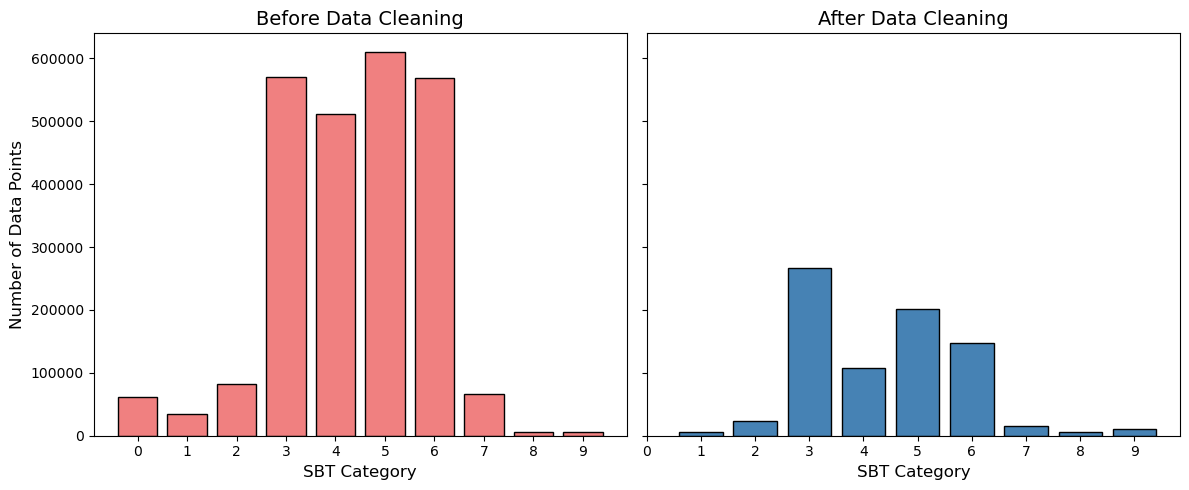

In [4]:
# Count occurrences of each SBT category (Before and After Cleaning)
sbt_counts_before = df["SBT (-)"].value_counts().sort_index()
sbt_counts_after = final_df["SBT_Zone"].value_counts().sort_index()

# Define unique SBT categories (ensuring all possible SBT values are included)
sbt_categories = np.arange(0, 10, 1)  # Assuming SBT ranges from 0 to 9

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# 📊 Plot - Before Cleaning
axes[0].bar(sbt_counts_before.index, sbt_counts_before.values, color="lightcoral", edgecolor="black")
axes[0].set_xlabel("SBT Category", fontsize=12)
axes[0].set_ylabel("Number of Data Points", fontsize=12)
axes[0].set_title("Before Data Cleaning", fontsize=14)
axes[0].set_xticks(sbt_categories)  # Ensure all SBT categories are displayed

# 📊 Plot - After Cleaning
axes[1].bar(sbt_counts_after.index, sbt_counts_after.values, color="steelblue", edgecolor="black")
axes[1].set_xlabel("SBT Category", fontsize=12)
axes[1].set_title("After Data Cleaning", fontsize=14)
axes[1].set_xticks(sbt_categories)  # Ensure all SBT categories are displayed

# Adjust layout and show plot
plt.tight_layout()
plt.show()
